# Class Activation Heatmap
Works for resnet pretrained or trained for less than ~5 epochs. Suspect the problem is with low predictions values and get an true_divide error..  
Changed labels to one hot decoding (and changed loss function) but did not help.

### Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [155]:
data_dir = pathlib.Path('/mnt/sdb/hyper-kvasir/labeled/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'self-trained',
    "ds_info": 'complete',
    "resample": False,
    "neg_class": ['normal-cecum'],
    "num_epochs": 1,
    "batch_size": 128,
    "img_shape": (224, 224, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

fine_tune_from = 130
fine_tune_epochs = 30
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [156]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Directories:  ['hemorrhoids' 'barretts' 'esophagitis-a' 'esophagitis-b-d'
 'ulcerative-colitis-0-1' 'barretts-short-segment' 'cecum' 'pylorus'
 'retroflex-rectum' 'ulcerative-colitis-grade-2'
 'ulcerative-colitis-grade-1' 'bbps-2-3' 'bbps-0-1' 'ileum'
 'retroflex-stomach' 'normal-z-line' 'ulcerative-colitis-2-3'
 'impacted-stool' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps'
 'ulcerative-colitis-grade-3' 'ulcerative-colitis-1-2']

hemorrhoids                 :    6 | 0.06%
barretts                    :   41 | 0.38%
esophagitis-a               :  403 | 3.78%
esophagitis-b-d             :  260 | 2.44%
ulcerative-colitis-0-1      :   35 | 0.33%
barretts-short-segment      :   53 | 0.50%
cecum                       : 1009 | 9.46%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-grade-1  :  201 | 1.89%
bbps-2-3                    : 1148 | 10.77%
bbps-0-1                    :  646 | 6.

In [157]:
def to_one_hot(img, lab):
    lab = tf.one_hot(lab, 23)
    return img, lab


train_ds = train_ds.unbatch().map(to_one_hot).batch(128)
test_ds = test_ds.unbatch().map(to_one_hot).batch(128)

In [158]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

### Callbacks

In [159]:
# By using LearnignRateScheduler
initial_learning_rate = config["learning_rate"]
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write(str(config))
f.close()

### Create and compile the model

In [160]:
def build_model(output_size, input_shape=(224, 224, 3), final_activation="softmax"):

    base_model = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )
    
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    output = Dense(output_size, activation=final_activation)(x)
    
    return Model(outputs=output, inputs=base_model.input)

In [161]:
model = build_model(
    output_size = params["num_classes"],
    input_shape = config["img_shape"],
    final_activation = config["final_activation"]
)

In [139]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=config["learning_rate"]),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [121]:
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Train the model

In [153]:
history = model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 1, #config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
58/58 [==============================] - 5s 89ms/step - loss: 0.0316 - categorical_accuracy: 0.9970 - val_loss: 9.3887 - val_categorical_accuracy: 0.0977


`Keras`
Save/load the model

Generate heatmap

In [162]:
import cv2

LAYER_NAME = 'conv5_block3_3_conv'

In [163]:
def bool_to_int(label):
    if isinstance(label, np.int32):
        return label
    return np.argmax(label)

Label: 18
polyps


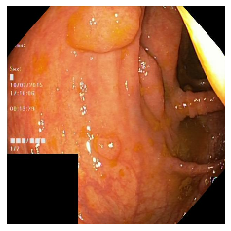

In [164]:
for images, labels in val_ds.take(1):
    img = images.numpy()[0]
    lab = labels.numpy()[0]

print ("Label:", bool_to_int(lab))
print (class_names[bool_to_int(lab)])
show_image(img)

img *= 255.0
CLASS_INDEX = bool_to_int(lab)

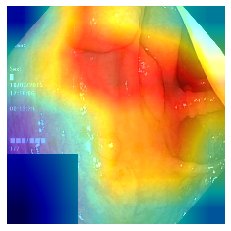

In [166]:
conv_layer = model.get_layer(LAYER_NAME)
grad_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (config["img_shape"][0:2]))
cam = np.maximum(cam, 0)

heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.6, 0)

show_image(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

# save_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imwrite("img.png", save_img)
# cv2.imwrite('cam.png', output_image)